<a href="https://www.kaggle.com/code/rishitdass/brain-tumor2?scriptVersionId=161849023" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import pathlib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importing Data

In [2]:
training_data='/kaggle/input/brain-tumor-mri-dataset/Training'
testing_data='/kaggle/input/brain-tumor-mri-dataset/Testing'

In [3]:
training_data=pathlib.Path(training_data)
testing_data=pathlib.Path(testing_data)

In [4]:
len(list(training_data.glob('*/*')))

5712

In [5]:
len(list(testing_data.glob('*/*')))

1311

In [6]:
data_set_training={
       'glioma_tumor': list(training_data.glob('glioma/*')),
       'meningioma_tumor':list(training_data.glob('meningioma/*')),
       'no_tumor': list(training_data.glob('notumor/*')),
       'pituitary_tumor': list(training_data.glob('pituitary/*')),
}

In [7]:
data_set_testing={
       'glioma_tumor': list(testing_data.glob('glioma/*')),
       'meningioma_tumor':list(testing_data.glob('meningioma/*')),
       'no_tumor': list(testing_data.glob('notumor/*')),
       'pituitary_tumor': list(testing_data.glob('pituitary/*')),
}

In [8]:
data_set_index={
       'glioma_tumor': 0,
       'meningioma_tumor': 1,
       'no_tumor': 2,
       'pituitary_tumor': 3,
}

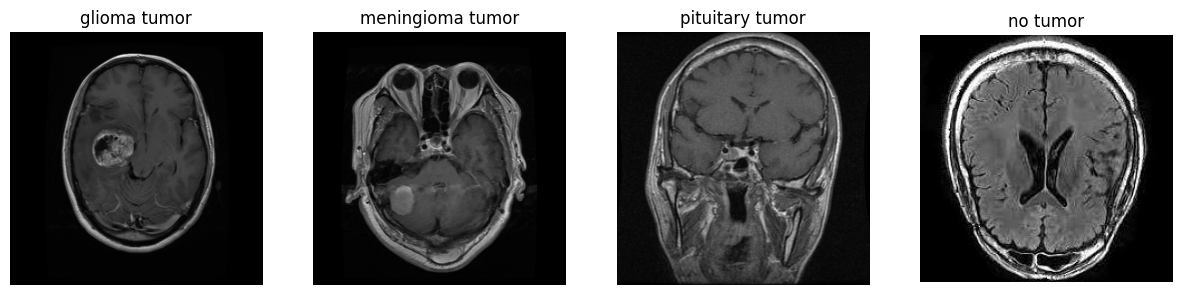

In [9]:
images=[data_set_testing['glioma_tumor'][4],data_set_testing['meningioma_tumor'][0],data_set_testing['pituitary_tumor'][4],data_set_testing['no_tumor'][10]]
names=['glioma tumor','meningioma tumor','pituitary tumor','no tumor']
image_cv=[cv2.imread(str(i)) for i in images]
fig, axs = plt.subplots(1, len(names), figsize=(15, 5))
for i in range(len(names)):
    axs[i].imshow(image_cv[i])
    axs[i].set_title(names[i])
    axs[i].axis('off')

# Image Preprocessing

In [10]:
cv2.imread(str(data_set_training['no_tumor'][0]))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [11]:
X=[]
y=[]
for tumor,images in data_set_training.items():
    for image in images:
        img=cv2.imread(str(image))
        #resizing image
        img=cv2.resize(img,(256,256))
        #gaussian Blur for noise reduction
        img = cv2.GaussianBlur(img, (3, 3), 0)
        #applying grey scalling
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #using CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
        contrast_enhanced_image = clahe.apply(gray_image)

        X.append(contrast_enhanced_image)
        y.append(data_set_index[tumor])

for tumor,images in data_set_testing.items():
    for image in images:
        img=cv2.imread(str(image))
        img=cv2.resize(img,(256,256))
        img = cv2.GaussianBlur(img, (3, 3), 0)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
        contrast_enhanced_image = clahe.apply(gray_image)

        X.append(contrast_enhanced_image)        
        y.append(data_set_index[tumor])

X=np.array(X)
y=np.array(y)

In [12]:
X.shape,y.shape

((7023, 256, 256), (7023,))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=0,test_size=0.2)

In [14]:
X_train.shape,X_test.shape

((5618, 256, 256), (1405, 256, 256))

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
#applying Normalization
X_train_scaled=X_train/255
X_test_scaled=X_test/255

In [17]:
y_test_categorical=keras.utils.to_categorical(y_test)
y_train_categorical=keras.utils.to_categorical(y_train)

# Training Model

In [18]:
model=keras.Sequential([
    
    layers.Conv2D(64,(3,3),activation='relu',input_shape=(256,256,1)),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.3),
    
    layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    layers.MaxPool2D(2,2), 
    layers.Dropout(0.3),
    
    layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    layers.MaxPool2D(2,2), 
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16,activation='relu'),
    layers.Dense(4,activation='softmax')
    
    
    
])

In [19]:
model.compile( loss='categorical_crossentropy',
               optimizer='adam',
             metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 64)        0

In [21]:
history=model.fit(X_train_scaled,y_train_categorical,epochs=15,validation_split=0.1)

Epoch 1/15


2024-02-06 00:17:08.157361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


158/158 [==============================] - 36s 187ms/step - loss: 1.0642 - accuracy: 0.5572 - val_loss: 0.6027 - val_accuracy: 0.7865
Epoch 2/15
158/158 [==============================] - 29s 182ms/step - loss: 0.5949 - accuracy: 0.7708 - val_loss: 0.4111 - val_accuracy: 0.8737
Epoch 3/15
158/158 [==============================] - 29s 183ms/step - loss: 0.4363 - accuracy: 0.8394 - val_loss: 0.2842 - val_accuracy: 0.8897
Epoch 4/15
158/158 [==============================] - 29s 185ms/step - loss: 0.3549 - accuracy: 0.8744 - val_loss: 0.2895 - val_accuracy: 0.8861
Epoch 5/15
158/158 [==============================] - 29s 186ms/step - loss: 0.3176 - accuracy: 0.8867 - val_loss: 0.2434 - val_accuracy: 0.8986
Epoch 6/15
158/158 [==============================] - 29s 186ms/step - loss: 0.2802 - accuracy: 0.8932 - val_loss: 0.2195 - val_accuracy: 0.9110
Epoch 7/15
158/158 [==============================] - 29s 186ms/step - loss: 0.2579 - accuracy: 0.9047 - val_loss: 0.2396 - val_accuracy: 0.9

# Performance assessement 

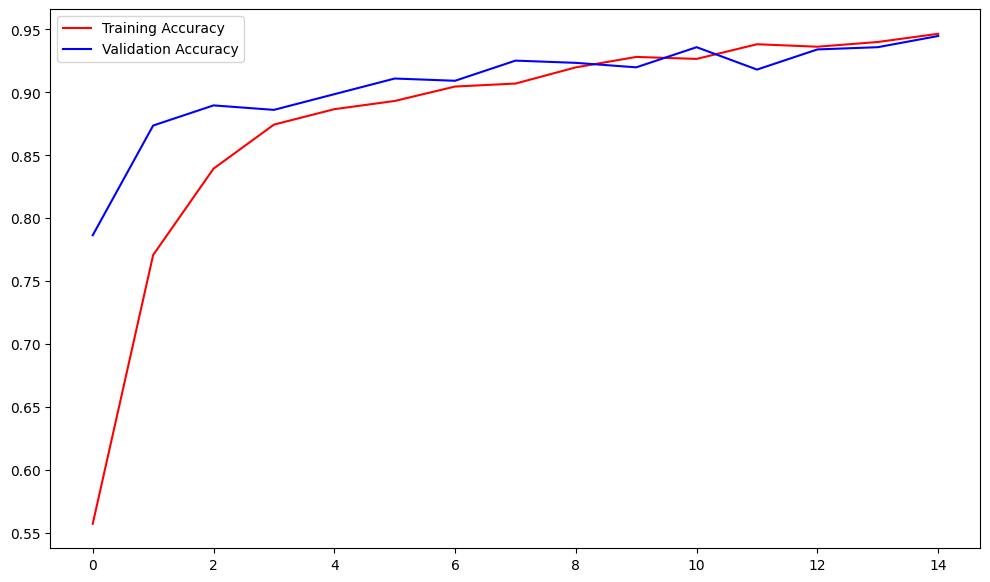

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(12,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

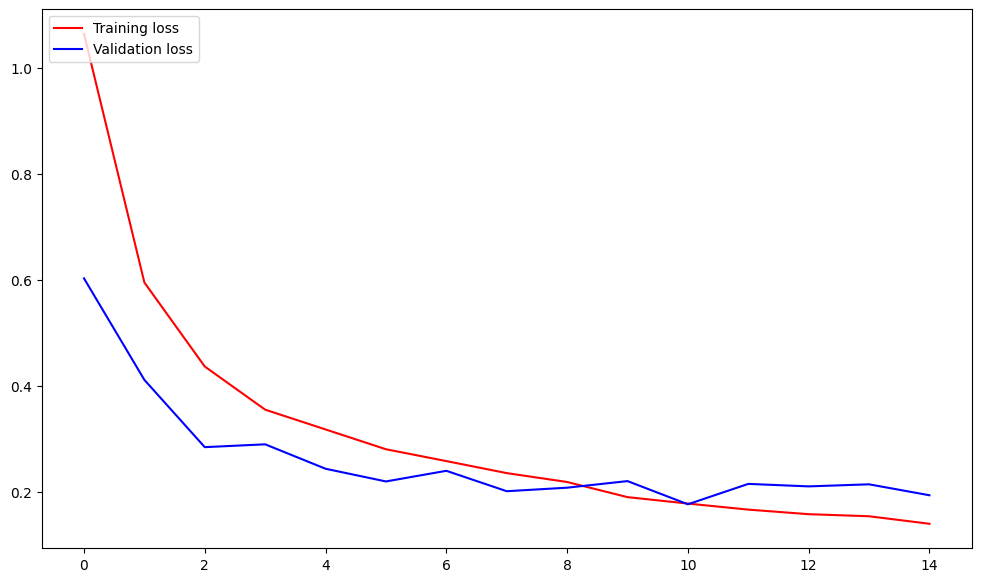

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(12,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix,classification_report

In [25]:
y_arr=model.predict(X_test_scaled)
y_arr[2]

44/44 [==============================] - 2s 38ms/step


array([1.0687645e-11, 6.0678576e-06, 2.6798991e-10, 9.9999392e-01],
      dtype=float32)

In [26]:
y_pred=[]
for i in y_arr:
    y_pred.append(np.argmax(i))
y_pred[2]

3

Text(0.5, 23.52222222222222, 'Predicted')

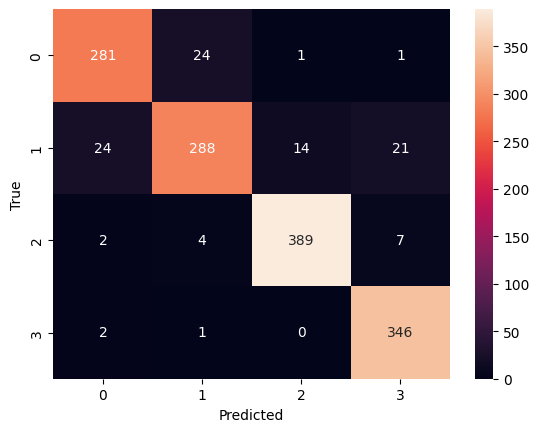

In [27]:
sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.ylabel('True')
plt.xlabel('Predicted')

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       307
           1       0.91      0.83      0.87       347
           2       0.96      0.97      0.97       402
           3       0.92      0.99      0.96       349

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405



In [29]:
model.evaluate(X_test_scaled,y_test_categorical)

44/44 [==============================] - 1s 24ms/step - loss: 0.2214 - accuracy: 0.9281


[0.22142423689365387, 0.9281138777732849]

In [30]:
# model.save('braintumorModel.h5')